In [12]:
import os
import lightkurve as lk
import astropy
from astropy.utils.masked import Masked
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from scipy import optimize
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

import sys
sys.path.insert(0, r'/Users/Student/OneDrive/MSci project/MSci2022_TESS/packages')
from unit_conversion import *

In [13]:
TIC = 'TIC 66818296' #WASP-17 / TIC 66818296

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
print("Search done")

# lc = lc_collection.stitch(corrector_func=lambda x: x.
#                           remove_nans().normalize(unit='unscaled'))
lc = lc_collection[0] #Sector 12

trying to download
Search done


In [14]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1624.9610687762238,———,———,5.7520936e-03,286200,1734.70083,254.40905,5.6597529e+03,2.7077772e+01,3.6572070e+04,1.5797379e+01,———,———,11000000000000,———,———,———,———,1734.70083,3.8966534e-03,254.40905,3.8714281e-03,———,———
1624.9624576649871,———,———,5.7520941e-03,286201,1734.69689,254.41390,5.6882363e+03,2.7163750e+01,3.6803297e+04,1.5849596e+01,———,———,11000000000000,———,———,———,———,1734.69689,3.8878899e-03,254.41390,3.8652457e-03,———,———
1624.9638465532857,———,———,5.7520941e-03,286202,1734.70053,254.41119,5.7022017e+03,2.7244625e+01,3.7047914e+04,1.5897677e+01,———,———,11000000000000,———,———,———,———,1734.70053,3.8902559e-03,254.41119,3.8693140e-03,———,———
1624.9652354420496,———,———,5.7520946e-03,286203,1734.70903,254.39842,5.6822319e+03,2.7329166e+01,3.7323707e+04,1.5950985e+01,———,———,11000000000000,———,———,———,———,1734.70903,3.9179092e-03,254.39842,3.8951968e-03,———,———
1624.9666243303482,———,———,5.7520946e-03,286204,1734.69178,254.41453,5.6716797e+03,2.7416311e+01,3.7592102e+04,1.6006865e+01,———,———,11000000000000,———,———,———,———,1734.69178,3.9340523e-03,254.41453,3.9140377e-03,———,———
1624.968013219112,———,———,5.7520950e-03,286205,1734.70877,254.40047,5.6360112e+03,2.7488678e+01,3.7820887e+04,1.6066200e+01,———,———,11000000000000,———,———,———,———,1734.70877,3.9713173e-03,254.40047,3.9468603e-03,———,———
1624.9694021074106,———,———,5.7520950e-03,286206,1734.70031,254.41046,5.6659849e+03,2.7556246e+01,3.8013035e+04,1.6101604e+01,———,———,11000000000000,———,———,———,———,1734.70031,3.9587538e-03,254.41046,3.9384109e-03,———,———
1624.9707909961744,———,———,5.7520955e-03,286207,1734.70983,254.39945,5.6488721e+03,2.7615194e+01,3.8208195e+04,1.6145405e+01,———,———,11000000000000,———,———,———,———,1734.70983,3.9820271e-03,254.39945,3.9563859e-03,———,———


In [15]:
lc = lc.normalize()
lc = lc.remove_outliers(sigma=10)

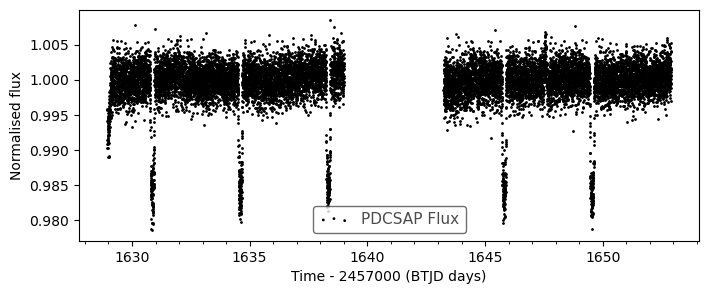

In [16]:
fig, axs = plt.subplots(1, figsize=(8, 3))
yes = lc.scatter(label='PDCSAP Flux', ax=axs, normalize=True, ylabel="Normalised flux", color='black')

axs.set_xlabel("Time - 2457000 (BTJD days)")

axs.xaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()

In [17]:
lc_f = lc.flatten()
lc_bin = lc_f.bin(time_bin_size = 0.006944444) # Default time is in days
#0.006944444 day = 10 minutes

cut = 1500
t = (lc_bin.time.mjd-lc_bin.time[0].mjd)[0:cut]
flux = lc_bin.flux[0:cut]
yerrs = lc_bin.flux_err[0:cut]


fig, ax = plt.subplots(1, figsize=(8,6))
plt.errorbar(t, flux, yerrs, fmt='.', color='Black', ecolor='LightGrey')


plt.ylabel("Normalised flux", size=17)
plt.xlabel("Time - 2457000 (BTJD days)", size=17)

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()


In [ ]:
#System
#http://exoplanets.org/detail/WASP-17b

# Semi-Major Axis[au]	0.04994 ± 0.00083
# Orbital Period[day]	3.7354330 +7.5×10-6/-7.7×10-6
# Orbital Eccentricity	0
# Orbit Inclination[deg]	86.63 +0.39/-0.45
# Argument of Periastron[deg]	90

# Time of Periastron[jd]	2454559.18096 +0.00025/-0.00021
# Transit Parameters
# Planetary Radius[rjupiter]	1.93 +0.052/-0.1
# Impact Parameter	0.400 +0.043/-0.04

# Stellar Properties
# Star Name	WASP-17
# Binary Flag	✗
# Mass of Star[msun]	1.190 ± 0.03
# Radius of Star[rsun]	1.200 +0.081/-0.08
# [Fe/H]	-0.250 ± 0.09
# Teff[k]	6550 ± 100
# Density of star[g/cm^3]	0.67 +0.16/-0.13
# log10(g)	4.20 ± 0.2
# Vsin(i)[km/s]	9.0 ± 1.5
# Gamma[km/s]	-49

In [ ]:
prior_params = batman.TransitParams()
prior_params.ecc = 0.0                                         #eccentricity
prior_params.w = 90.                                          #longitude of periastron (in degrees)
prior_params.limb_dark = "quadratic"                          #limb darkening model
prior_params.u = [0.21768792859790628, 0.2836292883489928]                             #limb darkening coefficients [u1, u2, u3, u4]


In [ ]:
def log_likelihood(prior_params, true_flux, yerrs):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    T_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis = prior_params

    prior_params.t0 = T_0
    prior_params.rp = R_planet_stellar
    prior_params.per = orbital_period
    prior_params.inc = orbital_inclination
    prior_params.a = semi_major_axis_in_stellar_radii(semi_major_axis, prior_params)
    
    
    guess_m = batman.TransitModel(prior_params, t)
    guess_flux = guess_m.light_curve(prior_params)
        
    L1 = -0.5 * np.power((true_flux - guess_flux), 2) / np.power(yerrs, 2) #Sigma
    L2 = -0.5 * np.log(2 * np.pi * yerrs**2) #Sigma
    L3 = np.sum(L1) + np.sum(L2)
    return L3


def log_prior(prior_params):
    """
    
    Parameters
    ----------


    Returns
    -------
    
    """
    T_0, R_planet_stellar, orbital_period, orbital_inclination, semi_major_axis = prior_params

    P = 0.0
    if (T_0 < 1.5) or (T_0 > 2.5): #Days
        P += -np.inf
        return -np.inf

    if (R_planet_stellar < 0.1) or (R_planet_stellar > 0.2):
        P += -np.inf
        return P

    if (orbital_period < 3.73538) or (orbital_period > 3.73556): #Days
        P += -np.inf
        return P

    if (orbital_inclination < 81) or (orbital_inclination > 90): #Degrees
        P += -np.inf
        return -np.inf
    

    if (semi_major_axis < 0) or (semi_major_axis > 0.07): #AU
        P += -np.inf
        return P

    return P

def log_prob(prior_params, true_flux, yerrs):
    lp = log_prior(prior_params)
    if (np.isinf(lp) == True):
        return -np.inf

    return log_likelihood(prior_params, true_flux, yerrs) + lp

In [ ]:
prior_t0 = 1.99 #Myself
prior_rprs = 0.1255 #Southworth et al. 2012
prior_per = 3.73548546 #(Days) Alderson et al. 2022
prior_inc = 86.71 #(Deg) Southworth et al. 2012
prior_a = 0.05151 #(AU) Bonomo et al. 2017
guess = [prior_t0, prior_rprs, prior_per, prior_inc, prior_a]

In [ ]:
scatter = [1E-4, 1E-4, 1E-4, 1E-2, 1E-3]

pos = guess + 1E-4 * np.random.randn(20, 5)

nwalkers, ndim = pos.shape

filename = "wasp_17b_sector12_a.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool() as pool:
    start_time = time.time()
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(flux, yerrs), a=2)
    sampler.run_mcmc(pos, 5000, progress=True)
    end_time = time.time()
    execution_time = (end_time - start_time)
    print("Start:       {}".format(time.ctime(int(start_time))))
    print("End:         {}".format(time.ctime(int(end_time))))
    print("Time taken:  {:.2f} s".format(execution_time))

emcee: Exception while calling your likelihood function:
  params: [1.98998770e+00 1.25343352e-01 3.73539034e+00 8.67100475e+01
 5.13760548e-02]
  args: (<Quantity [1.00063006, 0.99958843, 0.99933814, ...,        nan,        nan,
                  nan]>, <Quantity [0.00091692, 0.00112164, 0.00091469, ...,        nan,        nan,
                  nan]>)
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "c:\Users\Student\anaconda3\envs\MSci_project\lib\site-packages\emcee\ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "C:\Users\Student\AppData\Local\Temp\ipykernel_11764\4282502531.py", line 72, in log_prob
    return log_likelihood(prior_params, true_flux, yerrs) + lp
  File "C:\Users\Student\AppData\Local\Temp\ipykernel_11764\4282502531.py", line 14, in log_likelihood
    prior_params.t0 = T_0
AttributeError: 'numpy.ndarray' object has no attribute 't0'


AttributeError: 'numpy.ndarray' object has no attribute 't0'